In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def masstestAlt(mylist, locmodel):
    inputs =  all_photos[mylist]
    reals = all_normals[mylist]
    imgimg = locmodel.predict([inputs])
    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(imgimg, axis=1)
    r2 =  np.concatenate(reals, axis=1)
    finalimage = np.concatenate([r0, r1, r2], axis=0)
    return finalimage

In [4]:
locloc = "BigData" 
namename = "\TestBigPastel"
all_photos = np.load(locloc + namename + 'Photos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')

In [5]:
print(all_normals.shape)
print(all_photos.shape)

(6840, 64, 64, 3)
(6840, 64, 64, 3)


In [6]:
image_size = (64,64,3)

In [7]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    act1 = keras.layers.ReLU()(batch_norm1)
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    act2 = keras.layers.ReLU()(batch_norm2)
    return act2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    inputs = keras.layers.Input(image_size)
    
    skip1, encoder_1 = encoder(inputs, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*8)
    
    conv_block = ConvBlock(encoder_4, 32*16)
    
    decoder_1 = decoder(conv_block, skip4, 32*8)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    outputs = keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = get_U_Net(image_size)
model.summary()
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00004)
model.compile(optimizer=g_optimizer_image, loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

In [32]:
model.fit(all_photos, all_normals, epochs=5)

Epoch 1/5
214/214 [==============================] - 11s 53ms/step - loss: 0.0016
Epoch 2/5
214/214 [==============================] - 11s 52ms/step - loss: 0.0015
Epoch 3/5
214/214 [==============================] - 11s 51ms/step - loss: 0.0015
Epoch 4/5
214/214 [==============================] - 11s 51ms/step - loss: 0.0014
Epoch 5/5
214/214 [==============================] - 11s 51ms/step - loss: 0.0015


1/1 [==============================] - 0s 25ms/step
(384, 768, 3)
Сверху вниз: Ввод // Предсказание // Реальность


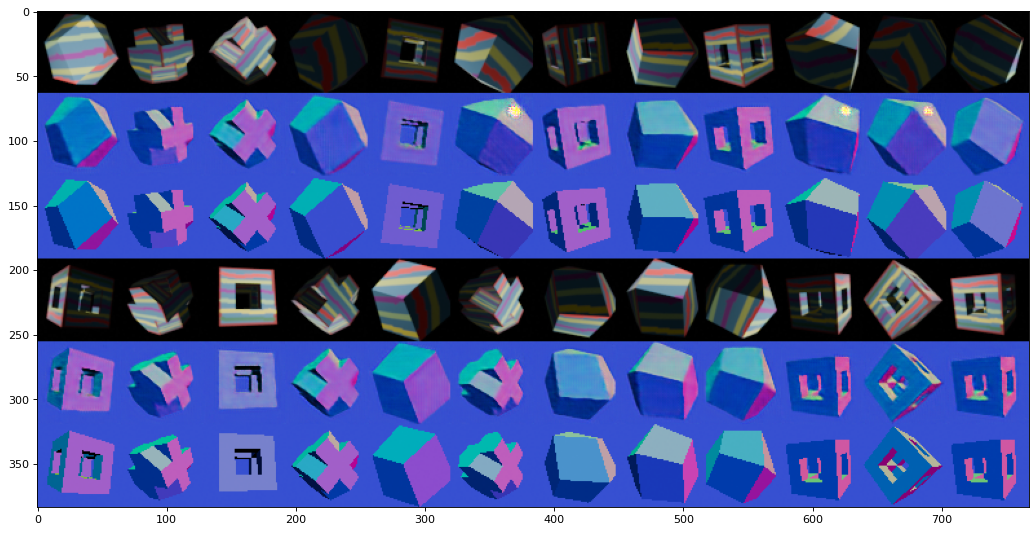

In [33]:
toinset = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([250, 750, 1250, 1750, 2250, 2750, 3250, 3750, 4250, 4750, 5250, 5750])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Предсказание // Реальность")
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [12]:
model.evaluate(test_photos, test_normals) 

32/32 [==============================] - 2s 30ms/step - loss: 0.0093


0.009258618578314781

1/1 [==============================] - 0s 23ms/step


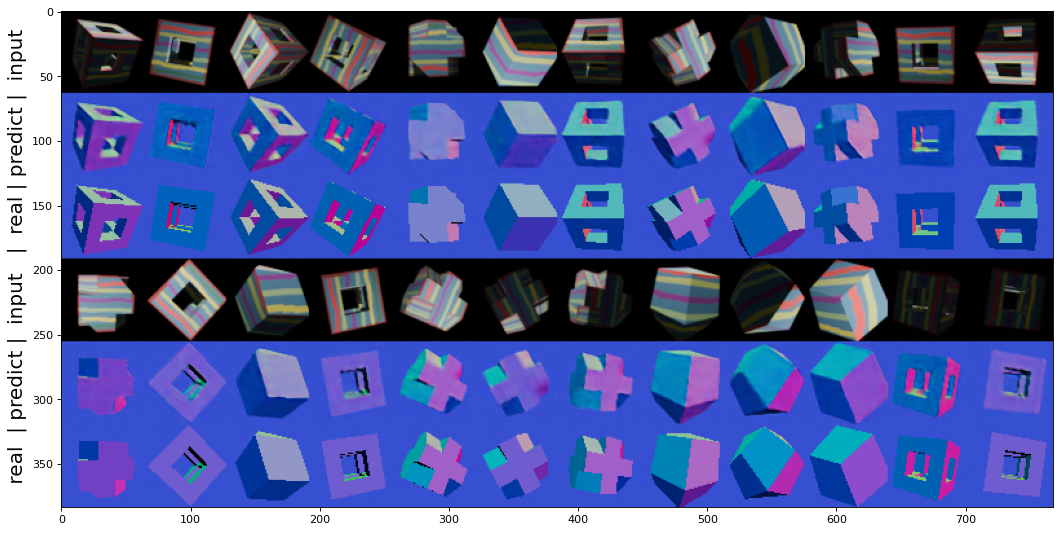

In [31]:
test_predictions = model.predict(test_photos_visual)

r0 =  np.concatenate(test_photos_visual[0:12], axis=1)
r1 =  np.concatenate(test_normals_visual[0:12], axis=1)
r2 =  np.concatenate(test_predictions[0:12], axis=1)
r4 =  np.concatenate(test_photos_visual[12:24], axis=1)
r5 =  np.concatenate(test_normals_visual[12:24], axis=1)
r6 =  np.concatenate(test_predictions[12:24], axis=1)
finalimage = np.concatenate([r0,  r2, r1, r4, r6, r5], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel(" real  | predict |  input   |  real | predict |  input", fontsize=18)
plt.imshow(finalimage.clip(0,1))

In [63]:
# Мне не нравится что на некоторых картинках появляются "прыщики" из сломанных пикселей.

In [2]:
locloc2 = "BigData" 
namename2 = "\TrainBigPastel"
all_test_normals = np.load(locloc2 + namename2 + 'Normals.npy')
test_normals = all_test_normals[0:1000]
test_normals_visual = all_test_normals[1000:1024]
del all_test_normals;
all_test_photoss = np.load(locloc2 + namename2 + 'Photos.npy')
test_photos = all_test_photoss[0:1000]
test_photos_visual = all_test_photoss[1000:1024]
del all_test_photoss;